start reading training data
[anchors.py] self.is_training_process = False
[anchors.py] image_shapes = [array([18, 80])]
[anchors.py] anchors = (32, 4)
[anchors.py] self.strides[idx] = 16
[anchors.py] shifted_anchors = (46080, 4)
[anchors.py] all_anchors = (46080, 4)
training iter:3700/3712, avg-time:0.01s, eta:0.11s, total_objs:[14317], usable_objs:[13545]

Best Possible Recall = 94.62283206798078%
training split finished precomputing
cfg.data.use_right_image = False
Number of training image = 3712


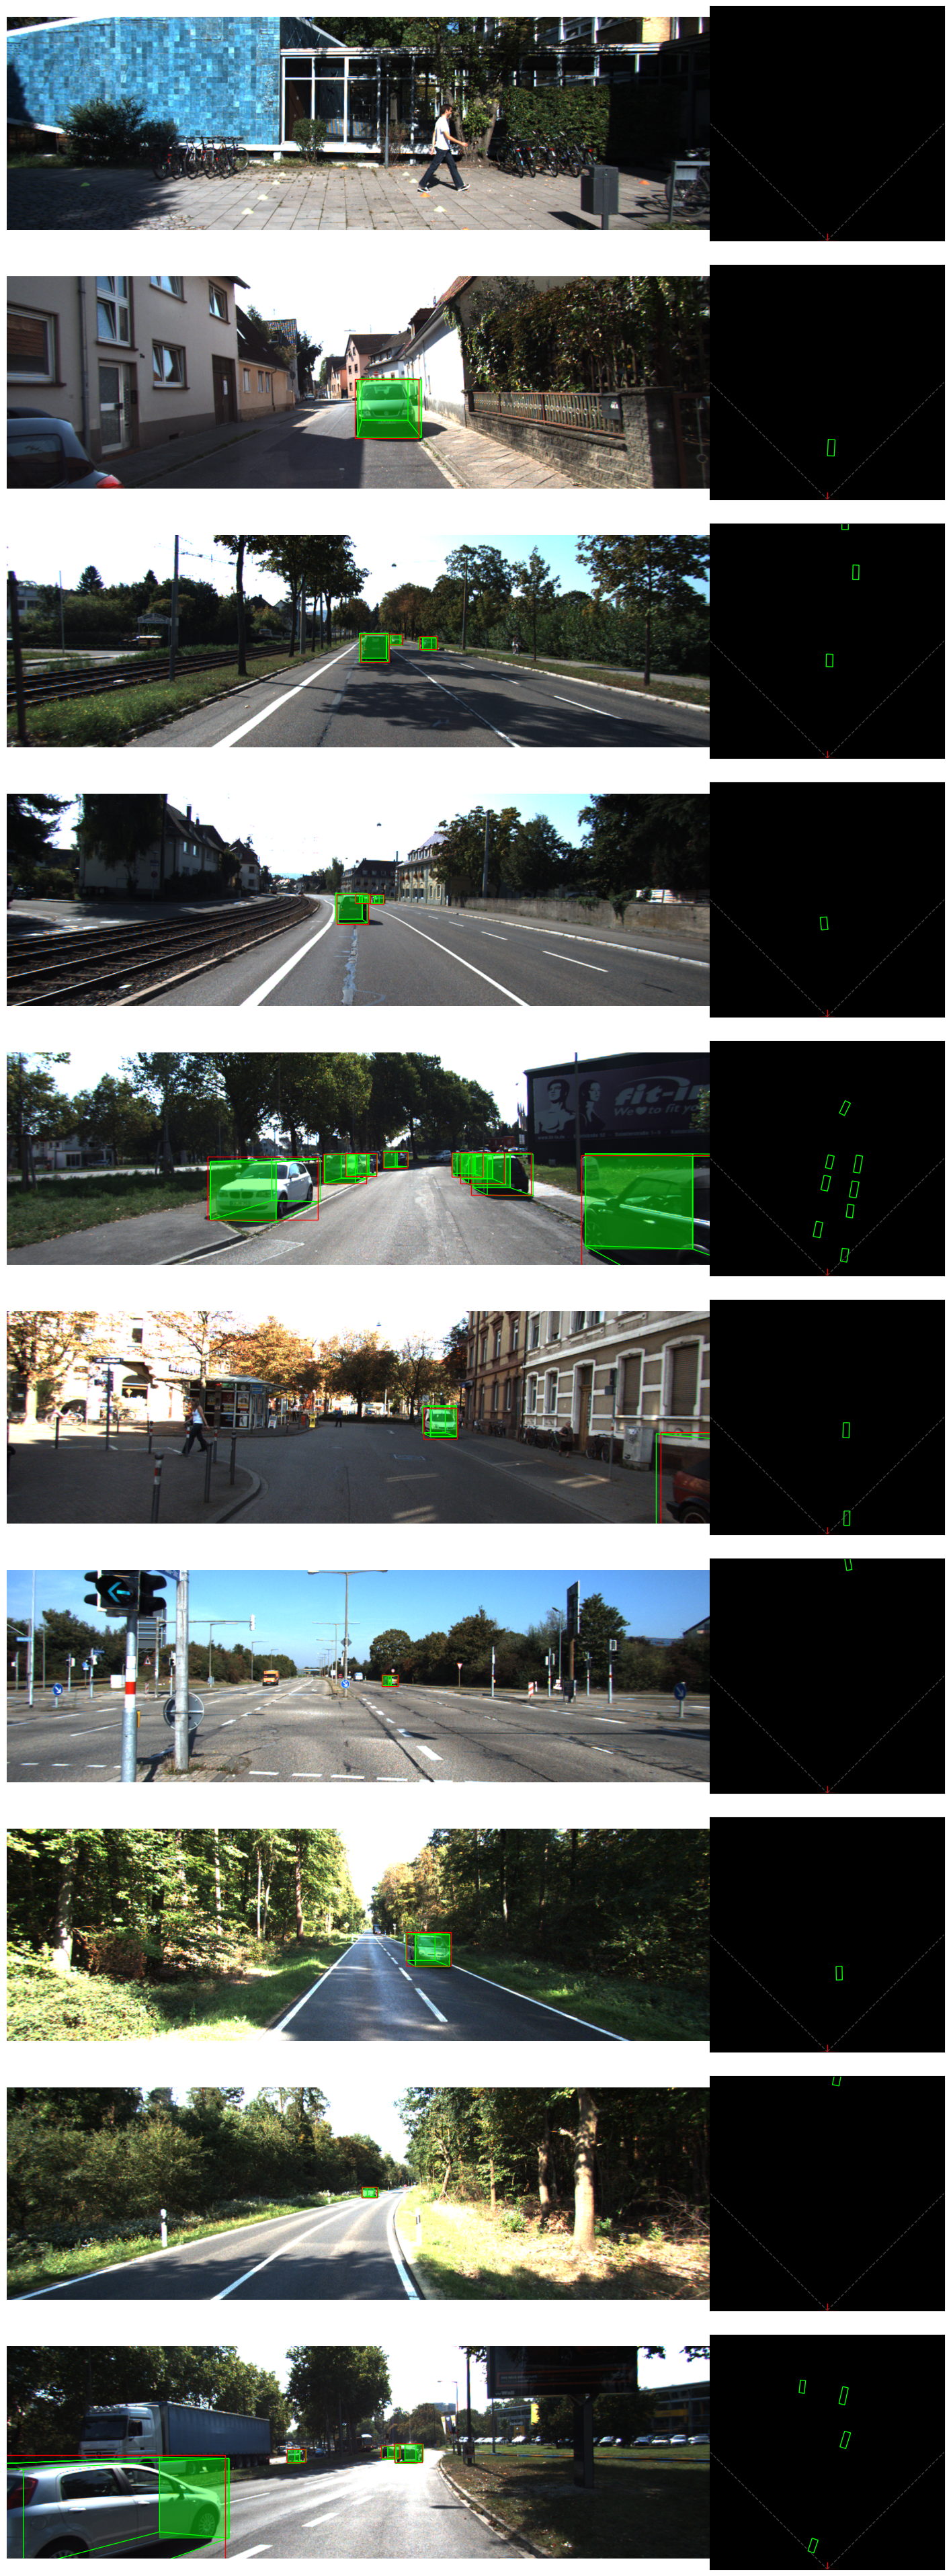

In [1]:
from __future__ import print_function, division
import sys
import os
import numpy as np
from math import pi, atan2
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

visualDet3D_path = os.path.dirname(sys.path[0])  #two folders upwards
sys.path.insert(0, visualDet3D_path)

from visualDet3D.utils.util_kitti import init_img_plt, draw_2Dbox, draw_corner_2D, draw_birdeyes, KITTI_Object, AVG_HEIGT
from visualDet3D.data.kitti_dataset import KittiDataset
from visualDet3D.utils.utils import cfg_from_file
from visualDet3D.data.preprocess import preprocess_train_dataset, process_train_val_file

NUM_IMG_SHOW = 10

# Load config for data augmentation visualization
cfg = cfg_from_file("config/data_augmentation_viz/data_augmentation_viz.py")

# Preprocess
train_names, val_names = process_train_val_file(cfg)
output_dict = {"calib": True,
                "image": True,
                "label": True,
                "velodyne": False,
                "depth": False,}
imdb_frames = preprocess_train_dataset(cfg, train_names, cfg.data.train_data_path, output_dict)

# Build DataLoader
dataset_train = KittiDataset(cfg, imdb_frames, split='training')

dataloader_train = DataLoader(dataset_train, 
                              num_workers = cfg.data.num_workers,
                              batch_size  = cfg.data.batch_size, 
                              collate_fn  = dataset_train.collate_fn, 
                              shuffle     = None, 
                              drop_last   = True,
                              sampler     = None)

print(f"cfg.data.use_right_image = {cfg.data.use_right_image}")
print(f"Number of training image = {len(dataloader_train)}")

imgs = []
objs = []
for iter_num, data in enumerate(dataloader_train):
    
    img = data[0][0]
    P2  = data[1][0].numpy()
    
    img = img.permute(1,2,0).to(torch.int).numpy()
    
    obj = []
    for obj_idx in range(len(data[2][0])):
        
        x1, y1, x2, y2              = data[3][0][obj_idx]
        cx, cy, cz, w, h, l, alpha  = data[4][0][obj_idx]
        
        # Convery cx,cy,cz to x3d,y3d,z3d
        loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
        loc_3d[1, 0] += AVG_HEIGT / 2.0
        
        # Convert alpha to rot_y
        rot_y = alpha + pi/2 - atan2(loc_3d[2, 0], loc_3d[0, 0])
        if   rot_y >  pi: rot_y -= 2*pi # make alpha in [-pi, pi]
        elif rot_y < -pi: rot_y += 2*pi
        
        obj.append( KITTI_Object(f"Car NA NA {alpha} {x1} {y1} {x2} {y2} {h} {w} {l} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA", P2) )
    # print(img)
    imgs.append(img[..., ::-1])
    objs.append(obj)
    
    if len(imgs) >= NUM_IMG_SHOW : break

axs = init_img_plt(imgs)

for i in range(NUM_IMG_SHOW):
    for obj_idx in range(len(objs[i])):
        color = [0, 1, 0]
        # Draw bbox
        draw_corner_2D(axs[i][0], objs[i][obj_idx].corner_2D, color = color, is_draw_front = True)
        draw_2Dbox    (axs[i][0], (objs[i][obj_idx].xmin, objs[i][obj_idx].ymin, objs[i][obj_idx].xmax, objs[i][obj_idx].ymax), color = [1,0,0])
        draw_birdeyes (axs[i][1], objs[i][obj_idx], color = color, title = "123", is_print_confident = False)
